In [22]:
!pip install scikit-learn --quiet

In [23]:
# imports
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import pandas as pd

In [24]:
# dados

iris = load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names

C:\Users\nicol\AppData\Local\Temp\ipykernel_32572\3782272892.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[f'k={k}' for k in ks], showmeans=True)


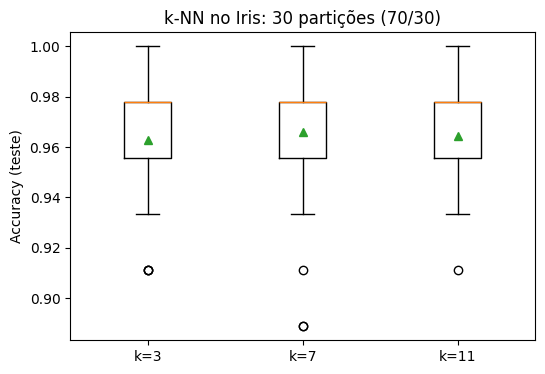

In [25]:
# 1)

# Partições estratificadas 70/30, 30 execuçõesd

sss = StratifiedShuffleSplit(n_splits=30, test_size=0.30, random_state=42)

ks = [3, 7, 11]
accuracies = {k: [] for k in ks}

for train_idx, test_idx in sss.split(X, y):
    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]
    for k in ks:
        knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
        knn.fit(X_tr, y_tr)
        y_pred = knn.predict(X_te)
        acc = accuracy_score(y_te, y_pred)
        accuracies[k].append(acc)

# Boxplot com whiskers

data = [accuracies[k] for k in ks]
plt.figure(figsize=(6,4))
plt.boxplot(data, labels=[f'k={k}' for k in ks], showmeans=True)
plt.ylabel('Accuracy (teste)')
plt.title('k-NN no Iris: 30 partições (70/30)')
plt.show()

In [26]:
# 2)

# Gerar UMA única partição estratificada 70/30
sss_one = StratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=7)
(train_idx, test_idx), = sss_one.split(X, y)

X_tr, X_te = X[train_idx], X[test_idx]
y_tr, y_te = y[train_idx], y[test_idx]

ks = [3, 7, 11]
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knn.fit(X_tr, y_tr)
    y_pred = knn.predict(X_te)

    cm = confusion_matrix(y_te, y_pred, labels=[0,1,2])
    df_cm = pd.DataFrame(cm, index=[f"true_{c}" for c in class_names],
                            columns=[f"pred_{c}" for c in class_names])

    print(f"\nMatriz de confusão — k={k}")
    display(df_cm)  # em notebooks Jupyter mostra tabulado


Matriz de confusão — k=3


,pred_setosa,pred_versicolor,pred_virginica
true_setosa,15,0,0
true_versicolor,0,14,1
true_virginica,0,1,14



Matriz de confusão — k=7


,pred_setosa,pred_versicolor,pred_virginica
true_setosa,15,0,0
true_versicolor,0,14,1
true_virginica,0,1,14



Matriz de confusão — k=11


,pred_setosa,pred_versicolor,pred_virginica
true_setosa,15,0,0
true_versicolor,0,14,1
true_virginica,0,1,14


### Exercício 2 — Alínea 3  
**Porque deve o valor de *k* ser ímpar (à luz da Fig. 3)?**

No algoritmo *k*-NN, cada ponto desconhecido é classificado segundo a **classe mais frequente**
entre os *k* vizinhos mais próximos.

- Se **k for par**, pode acontecer um **empate** entre classes (por exemplo 1–1 ou 2–2 num problema binário).  
  Nesse caso, o classificador precisa de um critério artificial de desempate
  (aleatório, prioridade de classe, ordem dos dados, etc.), o que introduz instabilidade.

- Se **k for ímpar**, garante-se que **há sempre uma maioria clara** entre as duas classes,
evitando empates e tornando o processo de decisão determinístico.

> 💡 **Conclusão:**  
> Escolher *k* ímpar (por exemplo 3, 5, 7, 11…) evita empates em problemas binários e reduz a probabilidade de empate em problemas multiclasse, tornando o *k*-NN mais estável e previsível.
